## Goal: What is the ratio of novel, not hg38 transcripts (hap. union) : novel transcripts in hg38?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

In [4]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
temp = df.loc[df.structural_category!='full-splice_match']

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hap1/2 
temp = temp.loc[(temp.hap1+temp.hap2)>0]
temp['n_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')


# 1. get those that are detected uniquely in hap1/2 
# (ie those not in hg38)
temp = temp.loc[(temp.hg38==False)&
                ((temp.hap1+temp.hap2)>0)]

# get total unique per cell line 
temp['n_non_hg38_novel_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')

temp = temp[['cell_line_id', 'n_novel_ic', 'n_non_hg38_novel_ic']].drop_duplicates()
assert len(temp.index) == len(temp.cell_line_id.unique())


In [5]:
temp2 = temp.copy(deep=True)

In [6]:
# get n novel for hg38
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

# 1.5 only novel ics and count per cell line
temp = df.loc[df.structural_category!='full-splice_match']

# get only the detection from mapping
temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
temp = temp.drop_duplicates()
temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                columns=['map_genome'],
                values=['detected'])

# flatten
temp.columns = temp.columns.get_level_values(1)
temp.columns.name = None

# reset index to make it a flat DataFrame
temp = temp.reset_index()

# fill missing values with False
temp = temp.fillna(False)

# 1.75. get those that are detected  in hg38
temp = temp.loc[temp.hg38==True]
temp['n_novel_ic_hg38'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')


In [7]:
temp2.head()

,cell_line_id,n_novel_ic,n_non_hg38_novel_ic
10,NA19390,19718,678
29,HG03729,20681,800
30,HG04217,20687,729
550,HG02261,26337,964
608,NA19307,15807,692


In [9]:
temp = temp[['cell_line_id', 'n_novel_ic_hg38']].drop_duplicates()
temp.head()

,cell_line_id,n_novel_ic_hg38
0,NA18561,14205
1,HG03719,17042
2,HG03729,19893
3,NA18542,21624
4,HG01975,17816


In [10]:
temp2 = temp2.merge(temp, how='left', on='cell_line_id')

In [11]:
temp2.head()

,cell_line_id,n_novel_ic,n_non_hg38_novel_ic,n_novel_ic_hg38
0,NA19390,19718,678,19107
1,HG03729,20681,800,19893
2,HG04217,20687,729,19984
3,HG02261,26337,964,25406
4,NA19307,15807,692,15133


In [12]:
temp2['ratio_novel'] = temp2['n_novel_ic']/temp2['n_novel_ic_hg38']


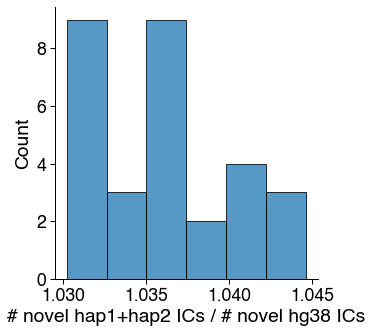

In [29]:
init_plot_settings(aspect='square')
ax = sns.displot(temp2, 
            x='ratio_novel')
ax.set(xlabel='# novel hap1+hap2 ICs / # novel hg38 ICs')

In [20]:
temp2['diff'] = temp2['n_novel_ic'] - temp2['n_novel_ic_hg38']

In [23]:
temp2.loc[temp2['diff']>temp2.n_non_hg38_novel_ic]
# sanity check

,cell_line_id,n_novel_ic,n_non_hg38_novel_ic,n_novel_ic_hg38,ratio_novel,diff


In [24]:
temp2.head()


,cell_line_id,n_novel_ic,n_non_hg38_novel_ic,n_novel_ic_hg38,ratio_novel,diff
0,NA19390,19718,678,19107,1.031978,611
1,HG03729,20681,800,19893,1.039612,788
2,HG04217,20687,729,19984,1.035178,703
3,HG02261,26337,964,25406,1.036645,931
4,NA19307,15807,692,15133,1.044538,674


## First, let's just look at the ratio between novels

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


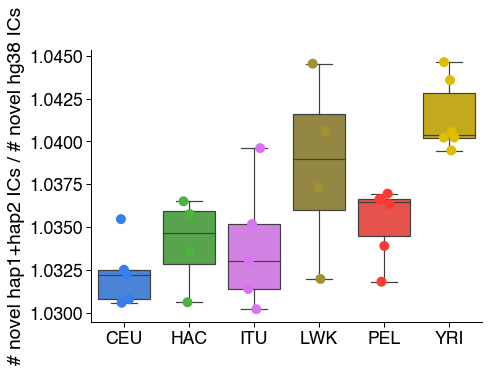

In [30]:
# do the plot by population too just because
temp2 = temp2.merge(meta_df[['cell_line_id_1000g', 'population']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')
init_plot_settings(aspect='rectangle')
c_dict, order = get_population_colors(cats=temp.population.unique().tolist())
ax = sns.boxplot(temp2,
            x='population',
            y='ratio_novel',
            palette=c_dict,
            order=order, 
            saturation=0.75,
            showfliers=False)
sns.stripplot(x='population', y='ratio_novel', data=temp2, jitter=True,
              palette=c_dict,
              order=order,
              size=10,
              edgecolor='k')
_ = ax.set(xlabel='', ylabel='# novel hap1+hap2 ICs / # novel hg38 ICs')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### Are these differences correlated at all to seq. depth?

In [31]:
temp = temp2.copy(deep=True)
temp = temp.merge(meta_df[['cell_line_id_1000g', 'map_reads_assemblymap']],
                    how='left',
                    left_on='cell_line_id',
                    right_on='cell_line_id_1000g')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cell_line_id_1000g_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


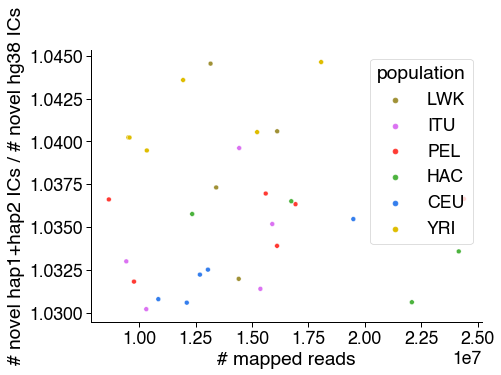

In [36]:
ax = sns.scatterplot(temp, y='ratio_novel', x='map_reads_assemblymap',
                    hue='population',
                    palette=c_dict)
ax.set(ylabel='# novel hap1+hap2 ICs / # novel hg38 ICs',
       xlabel='# mapped reads')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [33]:
x = temp.ratio_novel.tolist()
y = temp.map_reads_assemblymap.tolist()
r, r_p = st.pearsonr(x, y)
rho, rho_p = st.spearmanr(x, y)

print(r)
print(r_p)

print()

print(rho)
print(rho_p)

-0.024323405500706025
0.8984793978541536

0.07007786429365963
0.7128914578943152


In [34]:
# no, they're not correlated

[Text(0.5, 15.700000000000003, 'Population 2'),
 Text(33.7, 0.5, 'Popluation 1'),
 Text(0.5, 1.0, 'Population differences in (# novel hap1+hap2 ICs / # novel hg38 ICs)')]

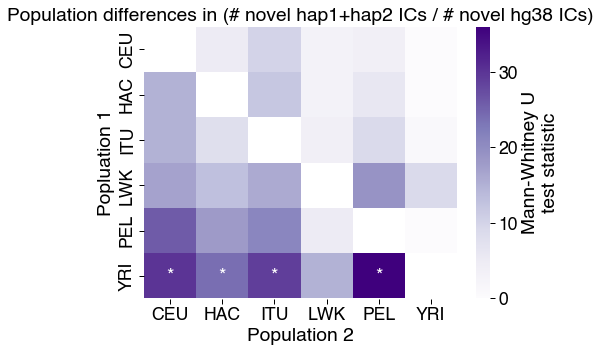

In [37]:
# test -- Mann-Whitney U for each pop. pair with hypothesis greater
import itertools

stat_df = pd.DataFrame()
for p1, p2 in list(itertools.permutations(temp.population.unique(), 2)):
    x = temp.loc[temp.population==p1,'ratio_novel'].tolist() # hyp. --> greater
    y = temp.loc[temp.population==p2,'ratio_novel'].tolist()
    
    try:
        stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    except:
        break
    temp3 = pd.DataFrame(data=[[p1, p2, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)
    del temp3
    
# fdr correction
from statsmodels.stats.multitest import multipletests
_, adj_p_vals, _, _ = multipletests(stat_df.pval.tolist(), method='fdr_bh')
stat_df['adj_pval'] = adj_p_vals
stat_df.head()

# add sig. annotation
# * <= 0.05
# ** <= 0.01
# *** <= 0.001
stat_df['sig_annot'] = ''
# stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
# stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
# stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

# pivot x2 to get a stat and annot df to plot
stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')

ax = sns.heatmap(stat_df1, cmap='Purples',
            annot=annot_df,
            fmt='',
            cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

# labels need them
ax.set(xlabel='Population 2',
       ylabel='Popluation 1',
       title='Population differences in (# novel hap1+hap2 ICs / # novel hg38 ICs)')